In [2]:
import sys
sys.path.append('../')
import importlib

import numpy as np
import torch

import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import seaborn as sbn
from contextlib import redirect_stdout
import json
import ast

import Classifier as clf
import UsefullFunctions as ufn

In [101]:
size = "big"
#size = "small"

with open('special_dataset.json', 'r') as json_file:
    data = json.load(json_file)

frates_actor = np.array(data["frates_actor"])
frates_critic = np.array(data["frates_critic"])
#final_actions = np.array(data["final_actions"])
#right_values = np.array(data["right_values"])
#left_values = np.array(data["left_values"])
#overall_values = np.array(data["overall_values"])
global_values = np.array(data["global_values"])
stimuli = np.array(data["stimuli"])
#timeav_values = np.array(data["timeav_values"])

In [104]:
net = {"X" : frates_actor, "network" : "actor"}
#net = {"X" : frates_critic, "network" : "critic"}

#label = {"Y" : final_actions, "label" : "actions"}
#label = {"Y" : right_values, "label" : "right_values"}
#label = {"Y" : left_values, "label" : "left_values"}
label = {"Y" : global_values, "label" : "global_values"}

#model = {"model" : 'perceptron', "param" : 0}
model = {"model" : 'perceptronL1', "param" : 0.01}
#model = {"model" : 'svm', "param" : 0.001}

In [105]:
#params = {"C": 0, "noise": 0}
#
#if size == "small":
#    params["C"] = 1e-2
#elif size == "big":
#    

----------
training score: 1.000
test score: 1.000 
----------


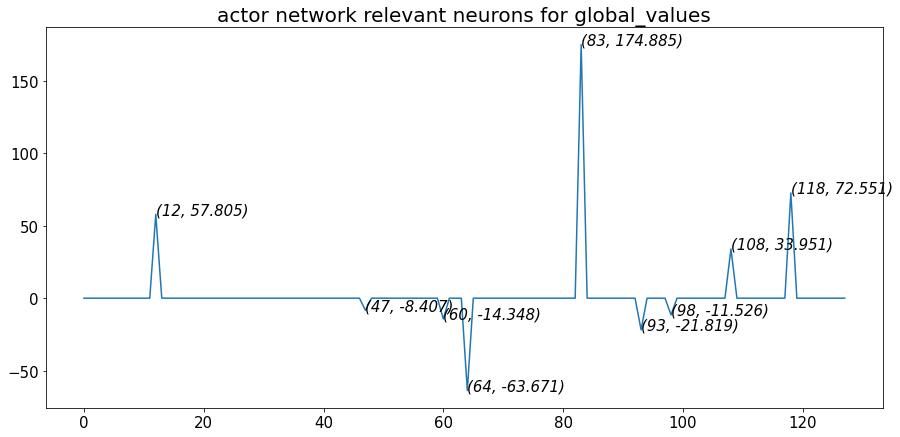

In [106]:
importlib.reload(clf)

clf.rel_neurons(X=net["X"], Y=label["Y"], model=model["model"], C=1e-2,\
               network=net["network"], label=label["label"], noise_mag=0, size=size)

In [107]:
if net["network"] == "actor":
    with open("clf_data_"+size+"/"+label["label"]+"/relevant_neurons_actor.json", 'r') as json_file:
        file_content = json.load(json_file)
else:
    with open("clf_data_"+size+"/"+label["label"]+"/relevant_neurons_critic.json", 'r') as json_file:
        file_content = json.load(json_file)

relevant_neurons = np.array(file_content["relevant_neurons"])
relevant_weights = np.array(file_content["relevant_weights"])
random_neurons = np.array(file_content["random_neurons"])
random_weights = np.array(file_content["random_weights"])
print(relevant_neurons)
#print(relevant_weights)
print(random_neurons)
#print(random_weights)

[ 83 118  64  12 108  93  60  98  47]
[107  75  54  89   2 102 120  74 116 105]


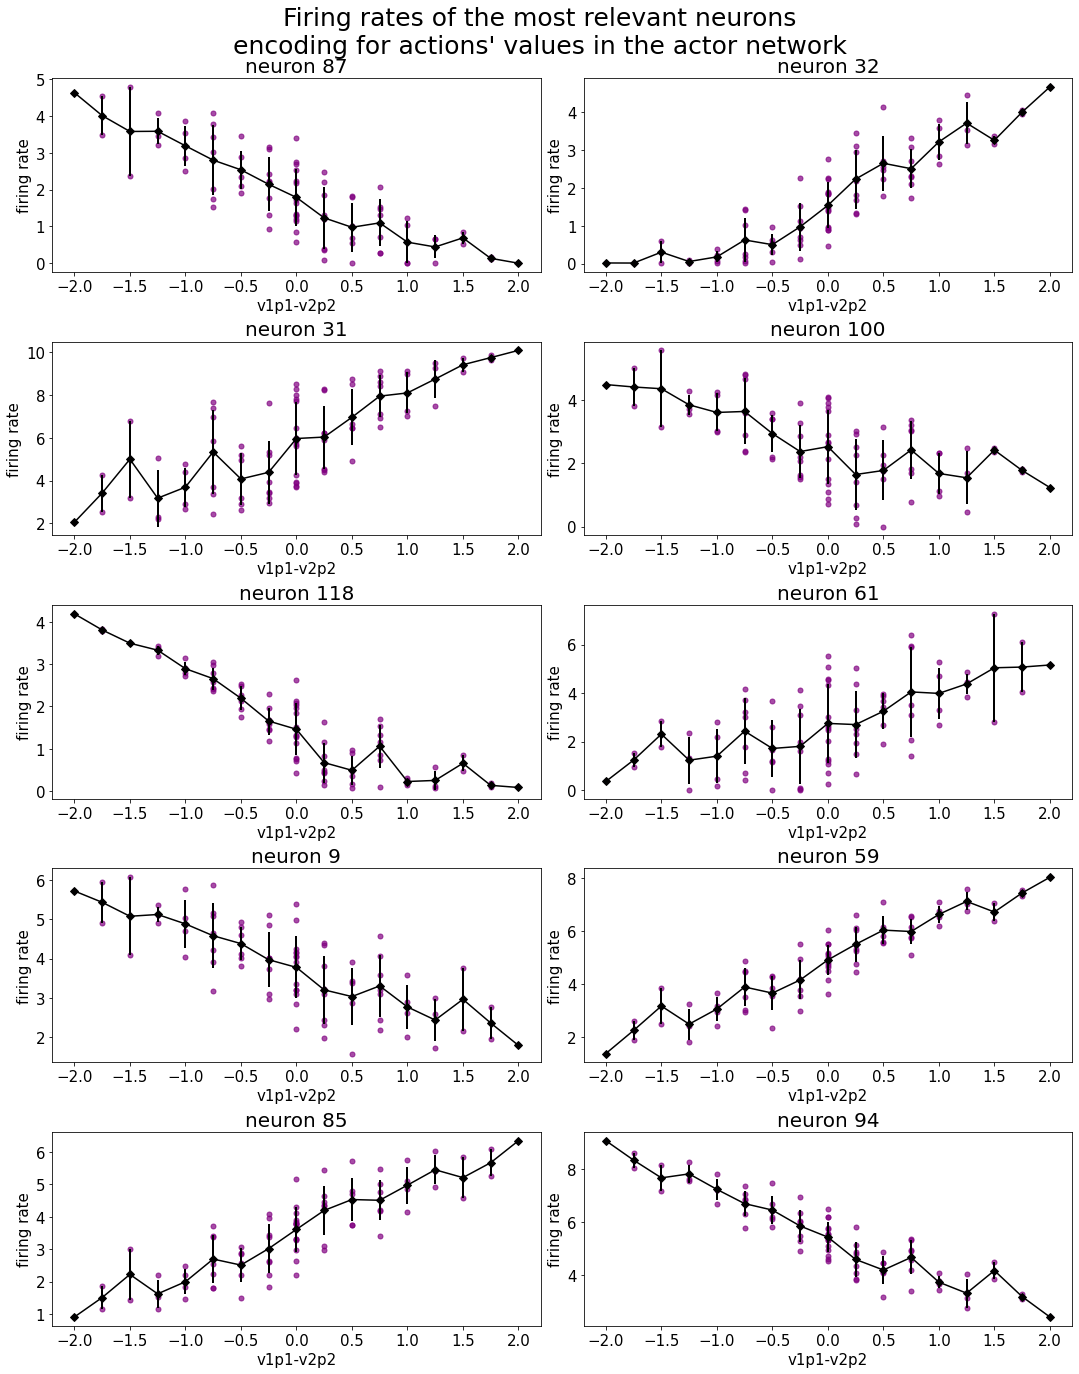

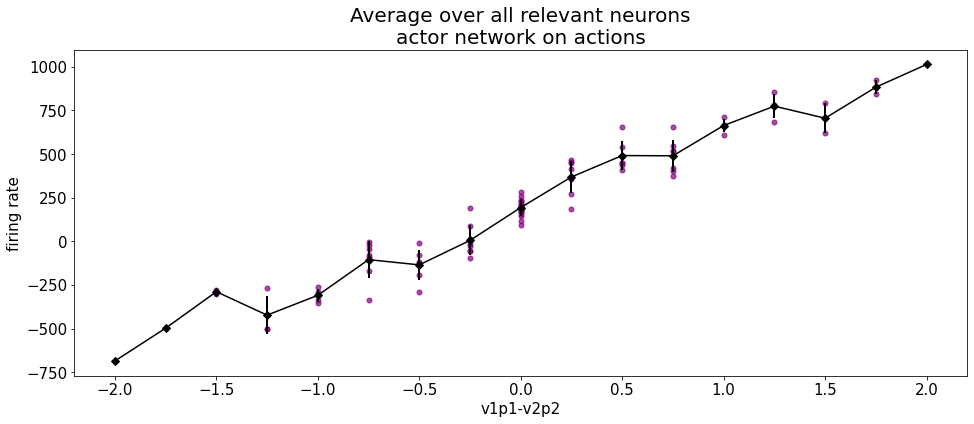

In [92]:
importlib.reload(ufn)

ufn.tuning_curves(relevant_neurons, relevant_weights, net["X"], stimuli, net["network"], label["label"])

In [ ]:
importlib.reload(ufn)

ufn.new_tuning_curves(relevant_neurons, relevant_weights, net["X"], stimuli, net["network"], label["label"])

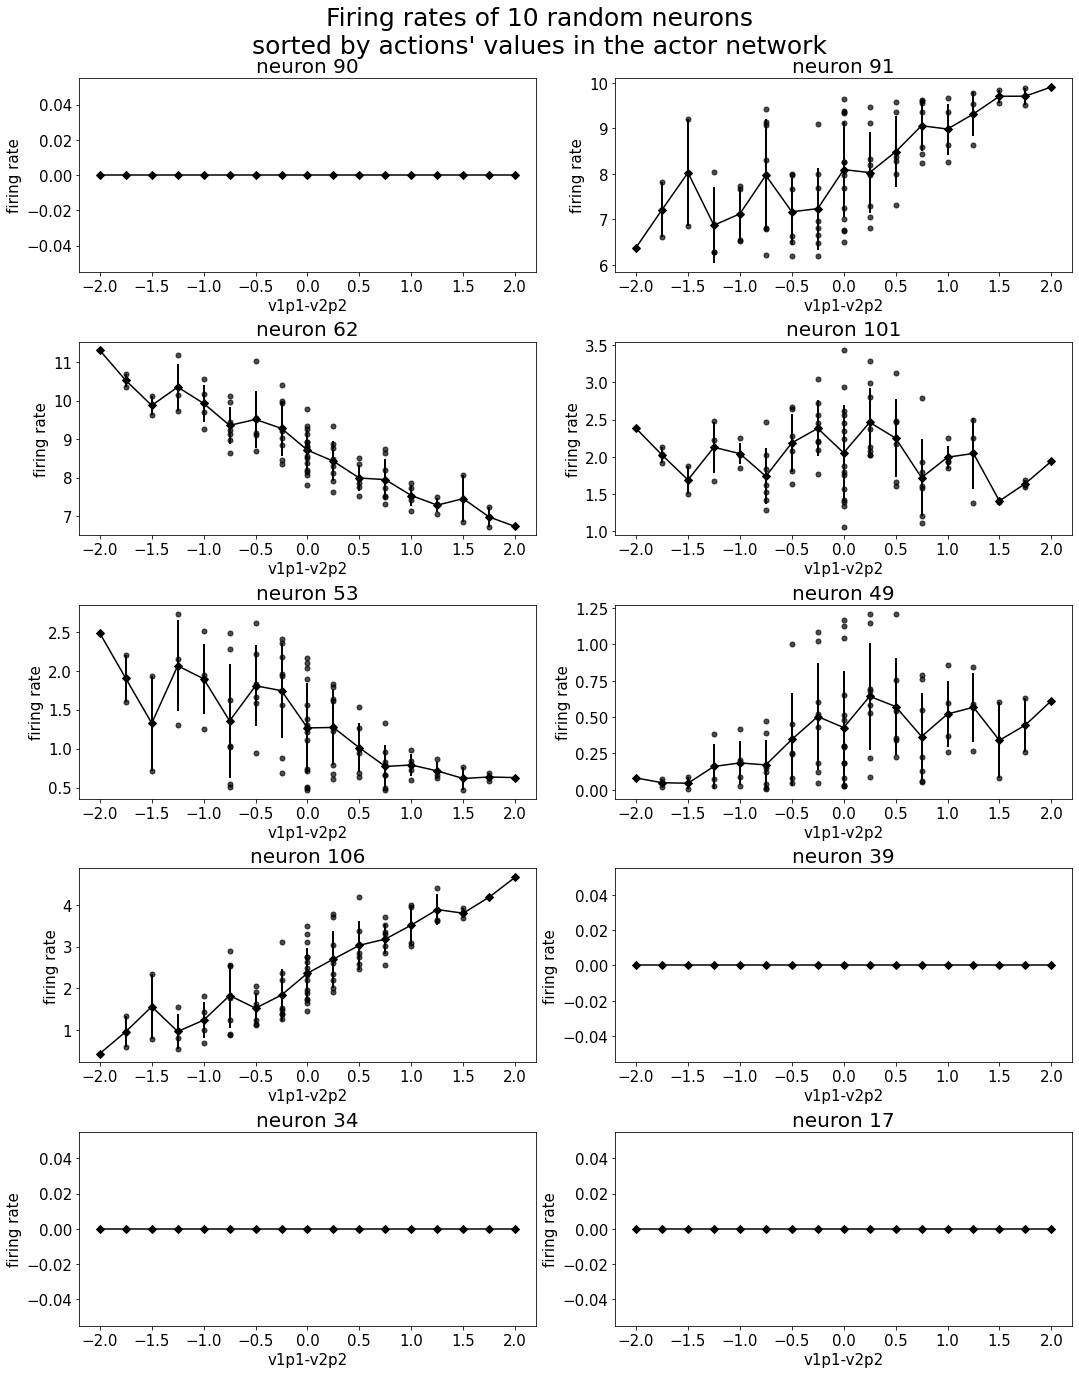

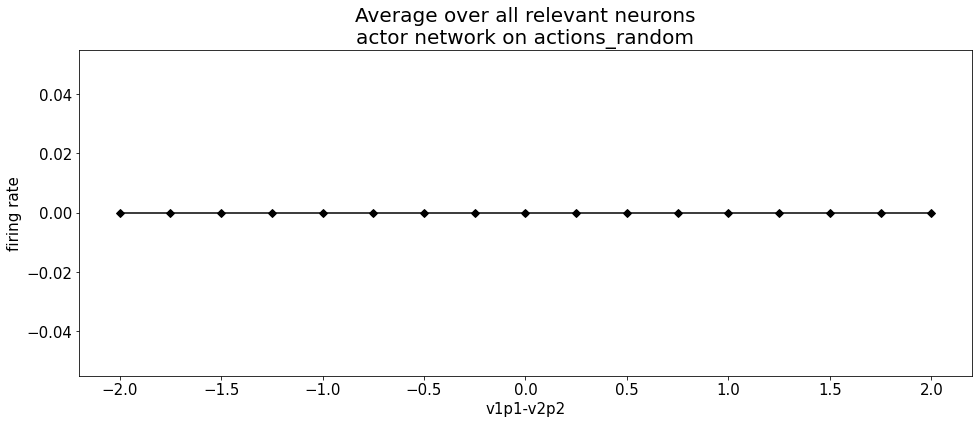

In [93]:
importlib.reload(ufn)

ufn.tuning_curves(random_neurons, random_weights, net["X"], stimuli, net["network"], label["label"]+"_random")

In [22]:
importlib.reload(ufn)

ufn.neurons_population(net["X"], label["Y"], net["network"], label["label"])

In [4]:
import json
import numpy as np
with open('neurons_population.json', 'r') as json_file:
    data = json.load(json_file)

averages = np.array(data["averages"])
stds = np.array(data["stds"])
dcs = np.array(data["dcs"])

In [5]:
averages

array([[1.00025660e+01, 1.80389292e+01],
       [0.00000000e+00, 0.00000000e+00],
       [3.61812560e+01, 5.35109477e+01],
       [2.92673436e+01, 4.28335372e+01],
       [0.00000000e+00, 0.00000000e+00],
       [7.74284245e+01, 7.52068941e+01],
       [0.00000000e+00, 0.00000000e+00],
       [3.00222104e+01, 4.33465891e+01],
       [0.00000000e+00, 0.00000000e+00],
       [2.63625610e+00, 4.61509736e-01],
       [2.01448057e+01, 1.63868709e+01],
       [0.00000000e+00, 0.00000000e+00],
       [4.72489235e+01, 5.54343454e+01],
       [2.47120666e+01, 2.27700538e+01],
       [0.00000000e+00, 0.00000000e+00],
       [5.56016451e+01, 5.98921176e+01],
       [6.38078622e+01, 6.60652304e+01],
       [0.00000000e+00, 0.00000000e+00],
       [5.19507386e+00, 1.11012083e+01],
       [2.94009119e+00, 7.63017178e+00],
       [0.00000000e+00, 0.00000000e+00],
       [5.14308354e+01, 5.32159864e+01],
       [5.13286837e+01, 5.50978559e+01],
       [1.67205675e-01, 1.09276095e-01],
       [4.769672